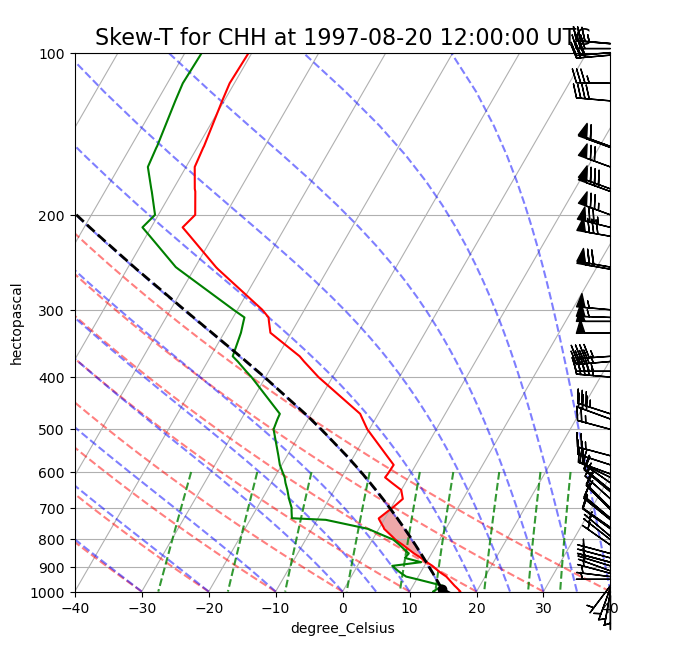

In [30]:
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime

# Step 1: Set up the time and station
time = datetime(1997, 8, 20, 12)  # 12Z = 12 UTC
station = 'CHH'  # Chatham, MA

# Step 2: Download the sounding data
df = WyomingUpperAir.request_data(time, station)

# Step 3: Pull out the variables and attach units
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
u = df['u_wind'].values * units.knots
v = df['v_wind'].values * units.knots

# Step 4: Create a Skew-T plot
fig = plt.figure(figsize=(7, 7))
skew = SkewT(fig)

# Plot temperature and dewpoint
skew.plot(p, T, 'red')
skew.plot(p, Td, 'green')

# Plot wind barbs
skew.plot_barbs(p, u, v)

# Set reasonable limits
skew.ax.set_xlim(-40, 40)
skew.ax.set_ylim(1000, 100)

# Add dry adiabats
skew.plot_dry_adiabats()

# Add moist adiabats
skew.plot_moist_adiabats()

# Add mixing ratio lines
skew.plot_mixing_lines()

import metpy.calc as mpcalc  # ADD THIS
import numpy as np           # ADD THIS if you haven't imported it

# Step 5: Calculate the parcel profile
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Step 6: Plot the parcel profile
skew.plot(p, parcel_prof, 'black', linestyle='--', linewidth=2)

# Step 7: Calculate LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.ax.plot(lcl_temperature.to('degC'), lcl_pressure, 'ko', markerfacecolor='black')

# Step 8: Shade CAPE area
skew.shade_cape(p, T, parcel_prof)

plt.title(f'Skew-T for {station} at {time} UTC', fontsize=16)
plt.show()


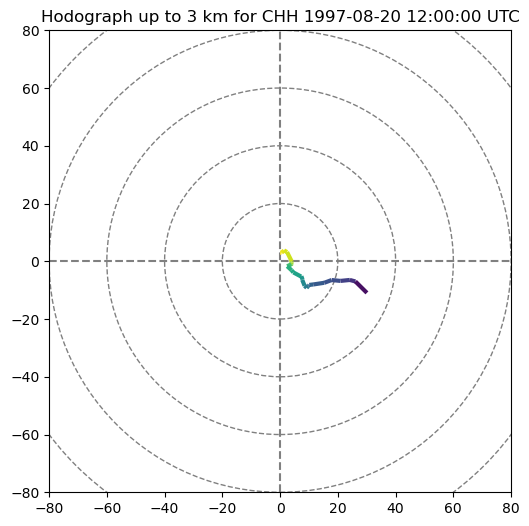

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import Hodograph
import metpy.calc as mpcalc
from metpy.units import units

# Assume you have these from your sounding:
# p, T, Td, u, v (with units)

# Step 1: Estimate height profile
# This calculates the approximate height above ground level
# We'll assume starting surface pressure = lowest p in profile
surface_pressure = p[0]
height = mpcalc.pressure_to_height_std(p)

# Step 2: Mask to only include up to 3000 meters
mask = (height <= 6000 * units.meter) & np.isfinite(u) & np.isfinite(v)

# Step 3: Create figure
fig, ax = plt.subplots(figsize=(6,6))

# Step 4: Plot hodograph for lowest 3 km
h = Hodograph(ax, component_range=80)
h.add_grid(increment=20)

# Use plot_colormapped so pressure still colors the lines
h.plot_colormapped(u[mask], v[mask], p[mask])

plt.title(f'Hodograph up to 3 km for {station} {time} UTC')
plt.show()


In [117]:
from collections import namedtuple
from datetime import datetime
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc
from siphon.simplewebservice.wyoming import WyomingUpperAir



def get_skewt_parameters(date_str, station, sounding_hr=0):
    date = datetime.strptime(date_str, "%Y-%m-%d").replace(hour=sounding_hr)
    df = WyomingUpperAir.request_data(date, station)
    Parameters = namedtuple("Parameters", "p T Td u v")
    fields = ["pressure", "temperature", "dewpoint", "u_wind", "v_wind"]
    params = [df[field].values * units[df.units[field]] for field in fields]
    return Parameters(*params)


def create_skew_T(params, station, date_str, sounding_hr):
    fig = plt.figure(figsize=(7, 7))
    skew = SkewT(fig)
    skew.ax.set_xlim(-40, 40)
    skew.ax.set_ylim(1000, 100)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    plt.title(f"STATION {station} DATE: {date_str} HOUR: {sounding_hr}Z")
    
    skew.plot(params.p, params.T, 'red')
    skew.plot(params.p, params.Td, 'green')
    skew.plot_barbs(params.p, params.u, params.v)
    parcel_prof = mpcalc.parcel_profile(params.p, params.T[0], params.Td[0]).to('degC')
    skew.plot(params.p, parcel_prof, 'black', linestyle='--', linewidth=2)
    skew.shade_cape(params.p, params.T, parcel_prof)
    skew.shade_cin(params.p, params.T, parcel_prof)
    lcl_p, _ = mpcalc.lcl(params.p[0], params.T[0], params.Td[0])
    cape, _ = mpcalc.cape_cin(params.p, params.T, params.Td, parcel_prof)
    fig.text(0.6, .8, f"LCL: {round(lcl_p,2)}\n CAPE: {round(cape,2)}", ha='center')
    return fig



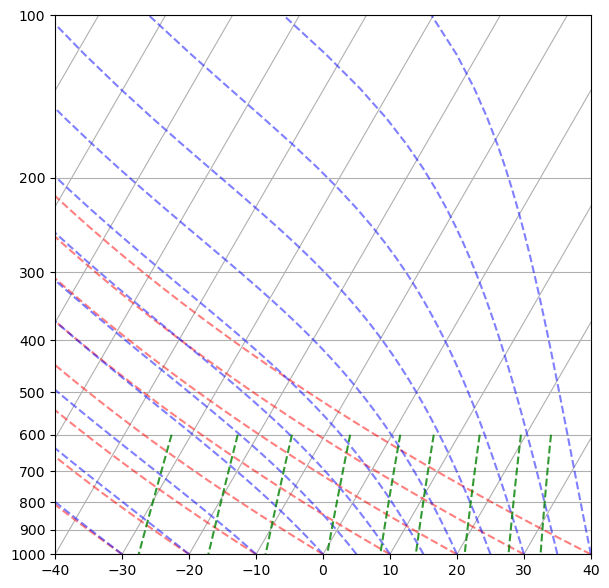

In [118]:
date_str = "1997-08-20"
station = "CHH"
sounding_hr = 12
params = get_skewt_parameters(date_str, station, sounding_hr)
fig = create_skew_T(params, station, date_str, sounding_hr)



why units

how is skewt integrated with matplotlib

what is siphon